In [2]:
import os

# Define dataset root path
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"

# Define processed image paths
processed_folder = os.path.join(dataset_path, "Processed_Images")
image_folder = os.path.join(processed_folder, "images")
mask_folder = os.path.join(processed_folder, "masks")

# ✅ Create necessary directories if they don’t exist
os.makedirs(processed_folder, exist_ok=True)
os.makedirs(image_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)

# ✅ Verify dataset structure
folders = ["TRAIN", "VAL", "TEST"]
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.exists(folder_path):
        print(f"✅ Found: {folder}")
    else:
        print(f"❌ Missing: {folder}")

print("✅ Dataset structure verified. Now ready for image processing!")


✅ Found: TRAIN
✅ Found: VAL
✅ Found: TEST
✅ Dataset structure verified. Now ready for image processing!


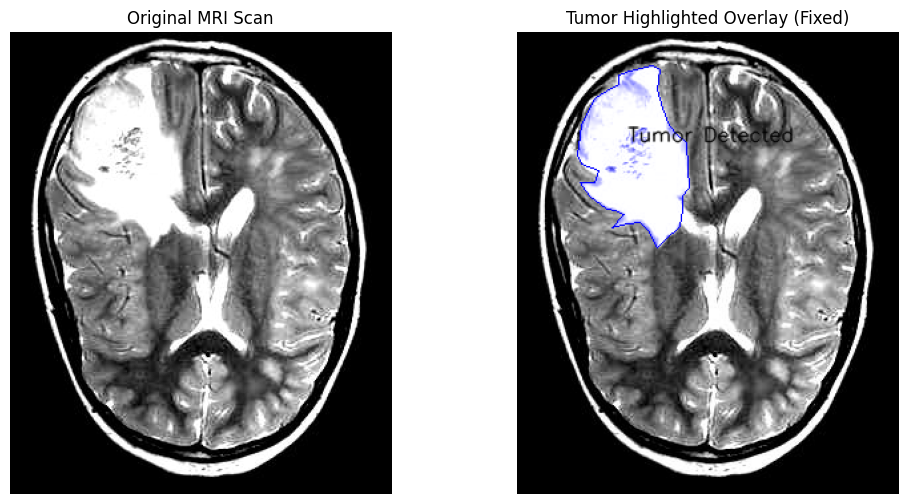

In [3]:
import os
import numpy as np
import cv2
import json
from tensorflow.keras.preprocessing.image import save_img

# ✅ Define dataset directories
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "original")

# ✅ Create necessary directories
os.makedirs(original_folder, exist_ok=True)

# ✅ Process images while maintaining original size
for folder in ["TRAIN", "VAL", "TEST"]:
    folder_path = os.path.join(dataset_path, folder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # ✅ Check if it's a valid image
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        # ✅ Load image in original size
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Skipping {img_name}, unable to read.")
            continue

        # ✅ Save original image without resizing
        save_img(os.path.join(original_folder, img_name), np.expand_dims(img, axis=-1))

print(f"✅ All original images saved in: {original_folder}")


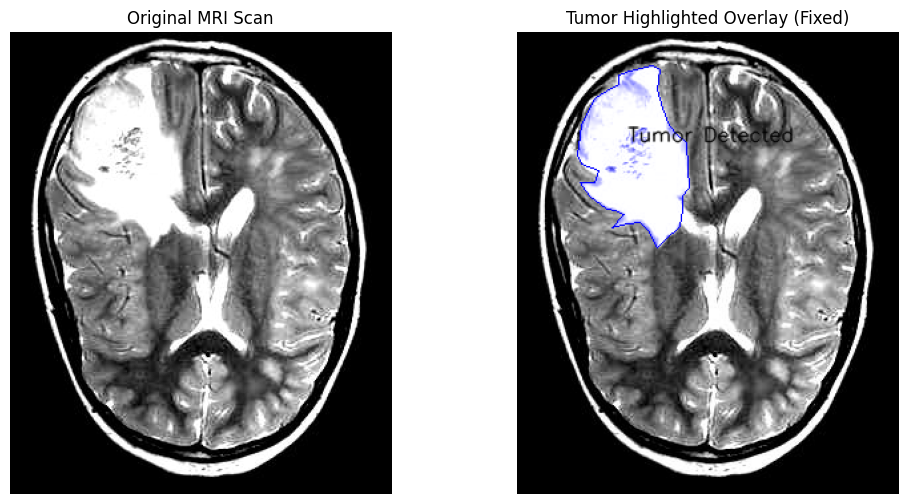

In [3]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ✅ Path to the dataset and annotation file
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"
annotation_file = os.path.join(dataset_path, "annotations_all.json")

# ✅ Load annotation data
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# ✅ Define a sample image (Modify this to test other images)
sample_image_name = "y0.jpg"  
sample_image_path = os.path.join(dataset_path, "TRAIN", sample_image_name)

# ✅ Load the original image without resizing
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
if sample_image is None:
    raise ValueError(f"Image {sample_image_name} not found or unable to load!")

original_size = sample_image.shape[:2]  # Get original image size (height, width)

# ✅ Normalize image for better visualization
sample_image = cv2.normalize(sample_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# ✅ Extract annotation key from JSON (Find the closest match)
matching_key = next((key for key in annotations.keys() if sample_image_name in key), None)
if not matching_key:
    raise ValueError(f"No matching annotation found for {sample_image_name}!")

sample_annotation = annotations[matching_key]  # Get corresponding annotation data

# ✅ Function to create a mask using the original image size
def create_mask_from_annotation(annotation, original_size):
    h_orig, w_orig = original_size  # Preserve original dimensions
    mask = np.zeros((h_orig, w_orig), dtype=np.uint8)
    contour_list = []  # Store contours for tumor boundary

    for region in annotation["regions"]:
        shape_attr = region["shape_attributes"]
        
        if shape_attr["name"] == "polygon":
            all_x = np.array(shape_attr["all_points_x"])
            all_y = np.array(shape_attr["all_points_y"])

            # **Ensure the annotation fits within the image dimensions**
            all_x = np.clip(all_x, 0, w_orig - 1)
            all_y = np.clip(all_y, 0, h_orig - 1)

            # Convert to contour format
            contour = np.array(list(zip(all_x, all_y)), dtype=np.int32)
            contour_list.append(contour)

            # Draw the tumor mask
            cv2.fillPoly(mask, [contour], 255)

    return mask, contour_list

# ✅ Generate tumor mask & contour using original size
sample_mask, contours = create_mask_from_annotation(sample_annotation, original_size)

# ✅ Convert grayscale image to 3-channel for overlaying
overlay_image = cv2.cvtColor(sample_image, cv2.COLOR_GRAY2BGR)

# ✅ Create an overlay with tumor annotation
colored_mask = np.zeros_like(overlay_image)
colored_mask[:, :, 2] = sample_mask  # Apply mask in **Red** channel

# ✅ Blend overlay with the original image
overlayed_image = cv2.addWeighted(overlay_image, 1, colored_mask, 0.6, 0)

# ✅ Draw tumor boundary in **Blue**
cv2.polylines(overlayed_image, contours, isClosed=True, color=(0, 0, 255), thickness=1)

# ✅ Add label near the tumor
if len(contours) > 0:
    M = cv2.moments(contours[0])
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(overlayed_image, "Tumor Detected", (cX - 5, cY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

# ✅ Display results
plt.figure(figsize=(12, 6))

# Original MRI scan
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap="gray")
plt.title("Original MRI Scan")
plt.axis("off")

# Overlayed MRI Scan with label and border
plt.subplot(1, 2, 2)
plt.imshow(overlayed_image)
plt.title("Tumor Highlighted Overlay (Fixed)")
plt.axis("off")

plt.show()


Processing All Images (Original + Overlayed)

In [4]:
import os
import numpy as np
import cv2
import json
from tensorflow.keras.preprocessing.image import save_img

# ✅ Define dataset directories
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "original")
overlay_folder = os.path.join(processed_folder, "overlay")

# ✅ Create folders if they don’t exist
os.makedirs(original_folder, exist_ok=True)
os.makedirs(overlay_folder, exist_ok=True)

# ✅ Load annotation JSON
annotation_file = os.path.join(dataset_path, "annotations_all.json")

with open(annotation_file, "r") as f:
    annotations = json.load(f)

# ✅ Overlay Parameters
alpha = 0.6  # Transparency level for overlay

# ✅ Function to create mask from annotation
def create_mask_from_annotation(annotation, original_size):
    h_orig, w_orig = original_size  # Preserve original dimensions
    mask = np.zeros((h_orig, w_orig), dtype=np.uint8)
    contour_list = []

    for region in annotation["regions"]:
        shape_attr = region["shape_attributes"]
        
        if shape_attr["name"] == "polygon":
            all_x = np.array(shape_attr["all_points_x"])
            all_y = np.array(shape_attr["all_points_y"])

            # Ensure coordinates stay within the image bounds
            all_x = np.clip(all_x, 0, w_orig - 1)
            all_y = np.clip(all_y, 0, h_orig - 1)

            # Convert to contour format
            contour = np.array(list(zip(all_x, all_y)), dtype=np.int32)
            contour_list.append(contour)

            # Draw the tumor mask
            cv2.fillPoly(mask, [contour], 255)

    return mask, contour_list

# ✅ Process all images from TRAIN, TEST, and VAL folders
for folder in ["TRAIN", "TEST", "VAL"]:
    folder_path = os.path.join(dataset_path, folder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # ✅ Check if it's a valid image
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        # ✅ Load the original image without resizing
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Skipping {img_name}, unable to read.")
            continue

        original_size = img.shape[:2]  # Store original height & width

        # ✅ Save original image (preserving aspect ratio)
        save_img(os.path.join(original_folder, img_name), np.expand_dims(img, axis=-1))

        # ✅ Extract base filename for lookup in JSON
        base_filename = os.path.splitext(img_name)[0]  
        matching_key = next((key for key in annotations.keys() if base_filename in key), None)

        if matching_key:
            mask, contours = create_mask_from_annotation(annotations[matching_key], original_size)

            # ✅ Convert grayscale image to 3-channel for overlaying
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            # ✅ Create an overlay mask
            colored_mask = np.zeros_like(img_color)
            colored_mask[:, :, 2] = mask  # Apply mask in **Red** channel

            # ✅ Blend overlay with the original image
            overlayed_image = cv2.addWeighted(img_color, 1, colored_mask, alpha, 0)

            # ✅ Draw tumor boundary in **Blue**
            cv2.polylines(overlayed_image, contours, isClosed=True, color=(0, 0, 255), thickness=2)

            # ✅ Add label near the tumor
            if len(contours) > 0:
                M = cv2.moments(contours[0])
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    cv2.putText(overlayed_image, "Tumor Detected", (cX - 5, cY - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

            # ✅ Save overlay image
            save_img(os.path.join(overlay_folder, img_name), overlayed_image)

print(f"✅ All original images saved in: {original_folder}")
print(f"✅ All overlay images saved in: {overlay_folder}")
    

✅ All original images saved in: C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\original
✅ All overlay images saved in: C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\overlay


In [8]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import save_img

# ✅ Define dataset directories
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "original")
overlay_folder = os.path.join(processed_folder, "overlay")
final_original_folder = os.path.join(processed_folder, "final_original")
final_overlay_folder = os.path.join(processed_folder, "final_overlay")

# ✅ Create necessary directories
os.makedirs(final_original_folder, exist_ok=True)
os.makedirs(final_overlay_folder, exist_ok=True)

# ✅ Target size (256x256) - Ensuring consistency
target_size = (256, 256)

# ✅ Function to resize both images while preserving alignment
def resize_pair(image, overlay, target_size):
    image_resized = cv2.resize(image, target_size)
    overlay_resized = cv2.resize(overlay, target_size)
    return image_resized, overlay_resized

# ✅ Process all images in the original and overlay folders
for img_name in os.listdir(original_folder):
    img_path = os.path.join(original_folder, img_name)
    overlay_path = os.path.join(overlay_folder, img_name)

    # ✅ Load images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    overlay = cv2.imread(overlay_path, cv2.IMREAD_COLOR)

    if img is None or overlay is None:
        print(f"⚠️ Skipping {img_name}, unable to read.")
        continue

    # ✅ Resize both images together
    img_resized, overlay_resized = resize_pair(img, overlay, target_size)

    # ✅ Save resized images
    save_img(os.path.join(final_original_folder, img_name), np.expand_dims(img_resized, axis=-1))
    save_img(os.path.join(final_overlay_folder, img_name), overlay_resized)

print(f"✅ All resized original images saved in: {final_original_folder}")
print(f"✅ All resized overlay images saved in: {final_overlay_folder}")


✅ All resized original images saved in: C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\final_original
✅ All resized overlay images saved in: C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\final_overlay


Splitting Dataset into Train/Val/Test

In [9]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split

# ✅ Define paths for final processed images
final_original_folder = os.path.join(processed_folder, "final_original")
final_overlay_folder = os.path.join(processed_folder, "final_overlay")

# ✅ Define train, validation, and test directories
train_folder = os.path.join(processed_folder, "train")
val_folder = os.path.join(processed_folder, "val")
test_folder = os.path.join(processed_folder, "test")

# ✅ Create subdirectories for images and masks
for split in [train_folder, val_folder, test_folder]:
    os.makedirs(os.path.join(split, "images"), exist_ok=True)
    os.makedirs(os.path.join(split, "masks"), exist_ok=True)

# ✅ Get list of image files
image_files = sorted(os.listdir(final_original_folder))

# ✅ Split into train, validation, and test sets (80%-10%-10%)
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

# ✅ Function to move images and masks into respective folders
def move_files(file_list, src_img_folder, src_mask_folder, dest_folder):
    for file_name in file_list:
        img_src = os.path.join(src_img_folder, file_name)
        mask_src = os.path.join(src_mask_folder, file_name)

        img_dest = os.path.join(dest_folder, "images", file_name)
        mask_dest = os.path.join(dest_folder, "masks", file_name)

        shutil.copy(img_src, img_dest)
        shutil.copy(mask_src, mask_dest)

# ✅ Move files to respective sets
move_files(train_files, final_original_folder, final_overlay_folder, train_folder)
move_files(val_files, final_original_folder, final_overlay_folder, val_folder)
move_files(test_files, final_original_folder, final_overlay_folder, test_folder)

print(f"✅ Train dataset: {len(train_files)} images")
print(f"✅ Validation dataset: {len(val_files)} images")
print(f"✅ Test dataset: {len(test_files)} images")

print(f"✅ Dataset split complete! Images saved in:")
print(f"   📂 {train_folder}")
print(f"   📂 {val_folder}")
print(f"   📂 {test_folder}")


✅ Train dataset: 640 images
✅ Validation dataset: 80 images
✅ Test dataset: 81 images
✅ Dataset split complete! Images saved in:
   📂 C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\train
   📂 C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\val
   📂 C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\test


Import Required Libraries

In [10]:
    import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array


Define U-Net Model

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

# ✅ Function to Build U-Net Model
def build_unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# ✅ Initialize U-Net Model
unet_model = build_unet()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss="binary_crossentropy",
                   metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])

unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Load Dataset

In [6]:
# ✅ Define dataset directories
train_images_path = os.path.join(processed_folder, "train/images")
train_masks_path = os.path.join(processed_folder, "train/masks")

val_images_path = os.path.join(processed_folder, "val/images")
val_masks_path = os.path.join(processed_folder, "val/masks")

test_images_path = os.path.join(processed_folder, "test/images")
test_masks_path = os.path.join(processed_folder, "test/masks")

# ✅ Function to Load Images & Masks
def load_data(image_folder, mask_folder):
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    images, masks = [], []
    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

        img = np.expand_dims(img, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# ✅ Load Train, Val, Test Data
X_train, Y_train = load_data(train_images_path, train_masks_path)
X_val, Y_val = load_data(val_images_path, val_masks_path)
X_test, Y_test = load_data(test_images_path, test_masks_path)

print(f"✅ Dataset Loaded: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")


✅ Dataset Loaded: Train=(640, 256, 256, 1), Val=(80, 256, 256, 1), Test=(81, 256, 256, 1)


In [7]:
# ✅ Train U-Net Model
history = unet_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,  # Adjust based on performance
    batch_size=8,  # Adjust based on available memory
    verbose=1
)

print("✅ Model training completed successfully!")


Epoch 1/20
80/80 [==============================] - 1723s 21s/step - loss: 0.5419 - accuracy: 0.1142 - mean_io_u: 0.4902 - val_loss: 0.4067 - val_accuracy: 0.1414 - val_mean_io_u: 0.4884
Epoch 2/20
80/80 [==============================] - 1687s 21s/step - loss: 0.4053 - accuracy: 0.1238 - mean_io_u: 0.4899 - val_loss: 0.4017 - val_accuracy: 0.1414 - val_mean_io_u: 0.4884
Epoch 3/20
80/80 [==============================] - 1755s 22s/step - loss: 0.3965 - accuracy: 0.1313 - mean_io_u: 0.4886 - val_loss: 0.4003 - val_accuracy: 0.1414 - val_mean_io_u: 0.4884
Epoch 4/20
80/80 [==============================] - 1784s 22s/step - loss: 0.4020 - accuracy: 0.1236 - mean_io_u: 0.4900 - val_loss: 0.3994 - val_accuracy: 0.1414 - val_mean_io_u: 0.4884
Epoch 5/20
80/80 [==============================] - 1676s 21s/step - loss: 0.3973 - accuracy: 0.1291 - mean_io_u: 0.4893 - val_loss: 0.3999 - val_accuracy: 0.1414 - val_mean_io_u: 0.4884
Epoch 6/20
80/80 [==============================] - 1762s 22s/ste


KeyboardInterrupt



In [11]:
import os
import numpy as np
import cv2
import json
import shutil
import matplotlib
import tensorflow as tf
import albumentations
import sklearn

# ✅ Create a dictionary to store versions
library_versions = {
    "os": "Built-in",
    "numpy": np.__version__,
    "opencv": cv2.__version__,
    "json": "Built-in",
    "shutil": "Built-in",
    "matplotlib": matplotlib.__version__,
    "tensorflow": tf.__version__,
    "albumentations": albumentations.__version__,
    "sklearn": sklearn.__version__,
}

# ✅ Print versions
print("\n🔍 Library Versions:")
for lib, version in library_versions.items():
    print(f"{lib}: {version}")

# ✅ Save versions to a file
version_file = "library_versions.txt"
with open(version_file, "w") as f:
    for lib, version in library_versions.items():
        f.write(f"{lib}: {version}\n")

print(f"\n✅ Library versions saved in {version_file}")



🔍 Library Versions:
os: Built-in
numpy: 1.19.5
opencv: 4.11.0
json: Built-in
shutil: Built-in
matplotlib: 3.6.3
tensorflow: 2.4.1
albumentations: 1.4.18
sklearn: 1.3.2

✅ Library versions saved in library_versions.txt


c:\users\suraj yadav\appdata\local\programs\python\python38\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
